# Predict Drought Level using Weather Dataset

##### Linoy Davari, Shachar Welkovitz and Yael Simhis

https://www.kaggle.com/cdminix/us-drought-meteorological-data

## Part 1 - Intro


### Content:

The Predict Droughts using Weather dataset classifies entries over six levels of drought, which is no drought (None in the dataset), and five drought levels shown below, according to their calculated score.
Each entry is a drought level at a specific point in time in a specific US county, accompanied by the last 90 days of 18 meteorological indicators shown in the bottom of this description, all related to the weather measured and to soil tests.
Furthermore, each entry is a timeseries entry that holds the results of the meteorological indicators. While 17 of them were measured daily, the score drought level was measured once a week only.

### Acknowledgements
These data were obtained from the NASA Langley Research Center (LaRC) POWER Project funded through the NASA Earth Science/Applied Science Program.

### Goal
Predict a drought score (as a regression problem) according to the meteorological data provided.

### Representing the Data and the Meteorological Indicators
The dataset's 21 columns provide information about the following:

1. FIPS - US conty FIPS code
2. Date - the observation date
3. PRECTOT - Percipitation (mm per 1 day)
4. PS -  Surface Pressure (kPa)
5. QV2M - Specific Humidity at 2 Meters (g/kg)
6. T2M - Temperature at 2 Meters (C)
7. T2MDEW - Dew/Frost Point at 2 Meters (C)
8. T2MWET - Wet Bulb Temperature at 2 Meters (C)
9. T2M_MAX - Maximum Temperature at 2 Meters (C)
10. T2M_MIN - Minimum Temperature at 2 Meters (C)
11. T2M_RANGE - Temperature Range at 2 Meters (C)
12. TS - Earth Skin Temperature (C)
13. WS10M - Wind Speed at 10 Meters (m/s)
14. WS10M_MAX - Maximum Wind Speed at 10 Meters (m/s)
15. WS10M_MIN - Minimum Wind Speed at 10 Meters (m/s)
16. WS10M_RANGE - Wind Speed Range at 10 Meters (m/s)
17. WS50M - Wind Speed at 50 Meters (m/s)
18. WS50M_MAX - Maximum Wind Speed at 50 Meters (m/s)
19. WS50M_MIN - Minimum Wind Speed at 50 Meters (m/s)
20. WS50M_RANGE - Wind Speed Range at 50 Meters (m/s)
21. score - Measure of drought ranging from 0 (no drought) to 5 (D4).


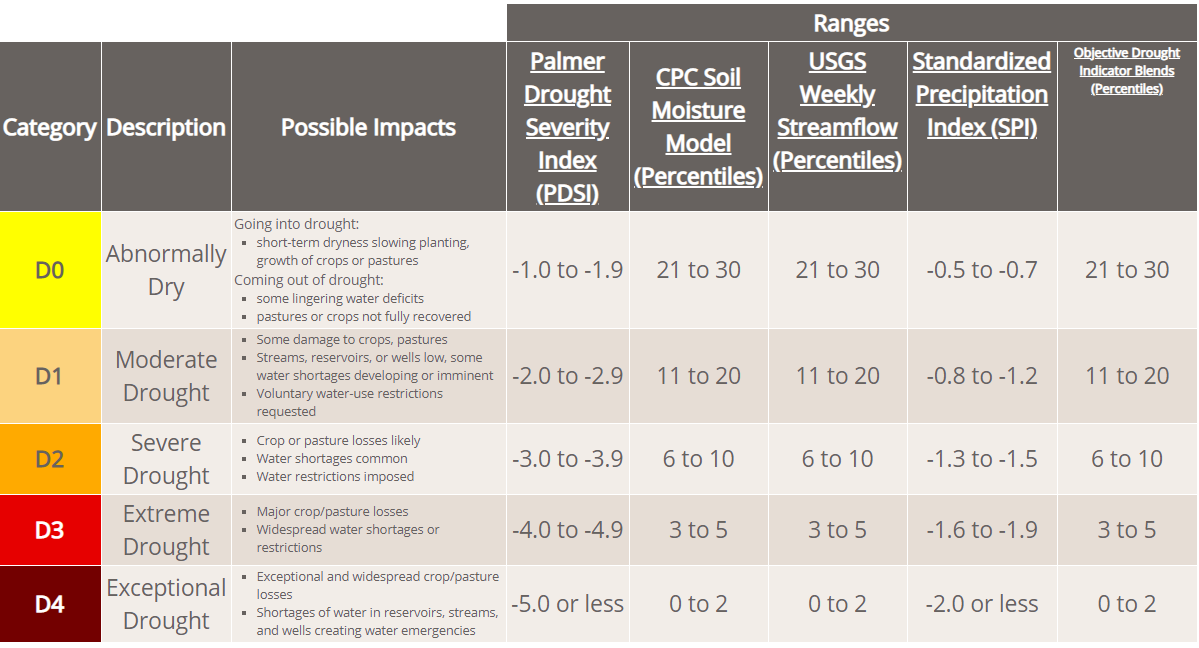

## Part 2 - Import Libraries

In [6]:
!pip install shap

     |████████████████████████████████| 356 kB 7.3 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491655 sha256=e08e37bf59e7d48860f7e59deeb6cea6cc8b5b25e0a12a89a4b62c698d3b891f
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [7]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import seaborn as sns
import os

sns.set()
sns.set_style('white')

import altair as alt
from tqdm.auto import tqdm
from tqdm.notebook import tqdm

import sklearn
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LassoCV, RidgeCV
from xgboost import XGBRegressor

import shap
import itertools

import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [52]:
from methods import mean_absolute_percentage_error, split_dataset_to_data_and_labels, plotModelResults, plotCoefficients, cross_validation_lasso, fit_ARIMA, cross_validation_arima, run_arima_and_plot_results, convert_reg_score_to_categories, plotRoc

#### Define Constant Variables 

In [8]:
TITLE_SIZE = 18
XLABEL_SIZE = 12
YLABEL_SIZE = 12
FIG_SIZE = (8,4)

## Part 3 - Loading the Data

In [9]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download cdminix/us-drought-meteorological-data
! unzip us-drought-meteorological-data.zip

root_path = '/content/'

files = {}

for dirname, _, filenames in os.walk(root_path):
  for filename in filenames:
    if filename == 'test_timeseries.csv':
        files['test'] = os.path.join(dirname, filename)
    if filename == 'train_timeseries.csv':
        files['train'] = os.path.join(dirname, filename)
    if filename == 'validation_timeseries.csv':
        files['validation'] = os.path.join(dirname, filename)

train_data = pd.read_csv(files['train'])
test_data = pd.read_csv(files['test'])
validation_data = pd.read_csv(files['validation'])

 99% 893M/901M [00:14<00:00, 94.8MB/s]
100% 901M/901M [00:14<00:00, 66.6MB/s]
Archive:  us-drought-meteorological-data.zip
  inflating: soil_data.csv           
  inflating: test_timeseries/test_timeseries.csv  
  inflating: train_timeseries/train_timeseries.csv  
  inflating: validation_timeseries/validation_timeseries.csv  


#### Drop rows with null values and Set the datetime column as index.

In [10]:
train_data = train_data.dropna()
train_data.date = pd.to_datetime(train_data.date)
train_data.set_index('date', inplace=True)

validation_data = validation_data.dropna()
validation_data.date = pd.to_datetime(validation_data.date)
validation_data.set_index('date', inplace=True)

test_data = test_data.dropna()
test_data.date = pd.to_datetime(test_data.date)
test_data.set_index('date', inplace=True)

## Part 4 - Data Visualization

####4.1. Occurrences of each drought level

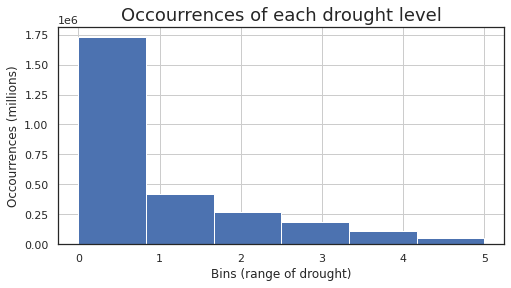

In [13]:
train_data.score.hist(bins=6, figsize=FIG_SIZE)
plt.xlabel("Bins (range of drought)", size=XLABEL_SIZE)
plt.ylabel("Occourrences (millions)", size=YLABEL_SIZE)
plt.title("Occourrences of each drought level", size=TITLE_SIZE)
plt.show()



*   There is an imbalance in the drought levels quantities.
*   Most of the examples in the dataset have no drought at all (1.75 milion examples with score between 0 and 1).



####4.2. Correlations between features - Heat Map

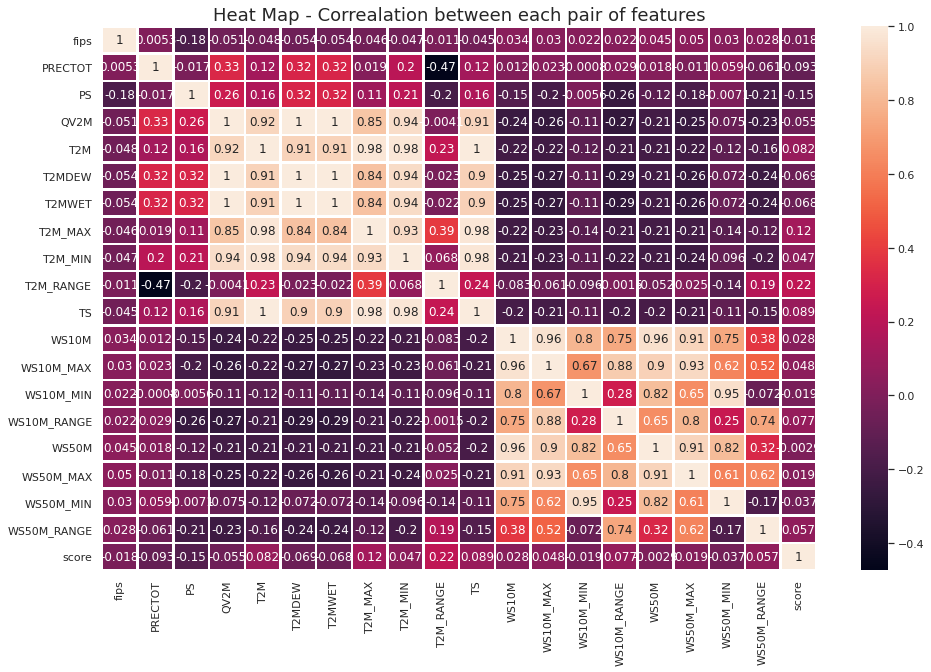

In [14]:
fix, ax = plt.subplots(figsize=(16,10))
plt.title("Heat Map - Correalation between each pair of features", size=TITLE_SIZE)
sns.heatmap(train_data.corr(method='spearman'),annot=True,linewidths=1.5)
plt.show()

The features that have the highest correlation with the target column, score are:

*   T2M_RANGE with 0.22 correlation rate.
*   T2M_MAX with 0.12 correlation rate.



####4.3. Exploring the Heat Map

#####4.3.1. Occurrences of the features that have the highest correlation with the target column

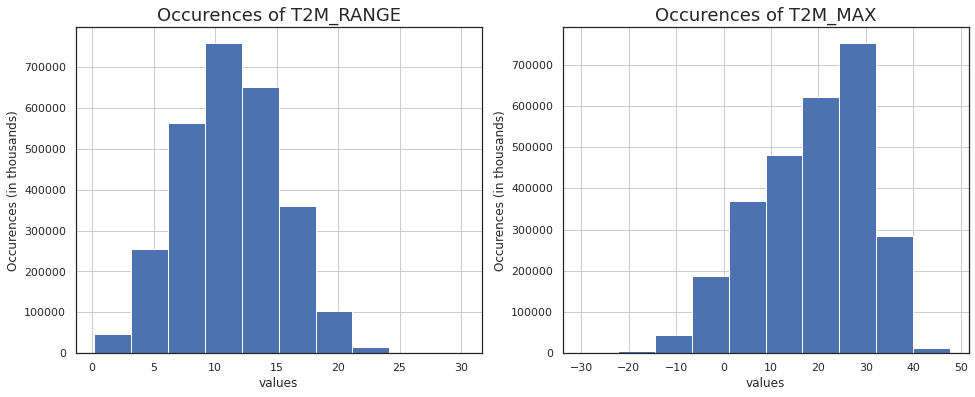

In [15]:
numeric_variables = ['T2M_RANGE','T2M_MAX']
fig, axes = plt.subplots(1, len(numeric_variables),figsize=(16,6))

for ind,var in enumerate(numeric_variables):
    train_data[var].hist(ax=axes[ind])
    axes[ind].set_title("Occurences of " + var, size=TITLE_SIZE)
    axes[ind].set_xlabel("values", size=XLABEL_SIZE)
    axes[ind].set_ylabel("Occurences (in thousands)", size=YLABEL_SIZE)

**T2M_RANGE** - The Temperature Range at 2 Meters:
*   is between 0 to 25.

*   The temperature range indicates that there are different temperature levels in the dataset to explore.

**T2M_MAX** - The Maximum Temperature at 2 Meters:
*   is between -20 to 50.

*   There are many examples with high maximum temperature that can indicate an high drought level.





#####4.3.2. The Affect of T2M_RANGE and WS50M_RANGE on the score



*   The WS50M_RANGE is the wind range speed at 50 Meters.
*   The T2M_RANGE is the temperature range at 2 Meters.
*   The range in both cases is the difference between the maximum value and the minimum value.
*   T2M_RANGE and WS50M_RANGE correlation rate is 0.19 which is approximately the same as the correlation between T2M_RANGE and score.

In [16]:
var_a = 'T2M_RANGE'
var_b = 'WS50M_RANGE'

data = train_data[:5000]
alt.Chart(data, title='Wind Speed and Temperature Affect on Score').mark_point().encode(
     x= var_a,
     y= var_b,
     color='score'
 ).interactive()

alt.Chart(...)

*   We can conclude that **low wind range** and **high temprature range** may cause in most cases an high score.


*   *Note: This graph is showing the results for only 5000 examples.*




#####4.3.3. The Affect of T2M_MAX and PS on the score 

*   The PS is the Atmospheric Pressure.
*   The T2M_MAX is the maximum temperature measured at 2 meters.
*   T2M_MAX and PS correlation rate is 0.11 which is approximately the same as the correlation between T2M_MAX and score.

In [17]:
var_a = 'T2M_MAX'
var_b = 'PS'

data = train_data[:5000]
alt.Chart(data, title='Atmospheric Pressure and Max Temperature Affect on Score').mark_point().encode(
     x= var_a,
     y= var_b,
     color='score',
 ).interactive()

alt.Chart(...)

*   We can conclude that **high maximum temperature** causes **high score**.
*   The PS rate has no drastic change, so it's not affecting the score.


*   *Note: This graph shows the results for only 5000 examples.*

####4.4. Seasonality, Trends and Stationarity

#####4.4.1. Resampling the Data by Years and Months

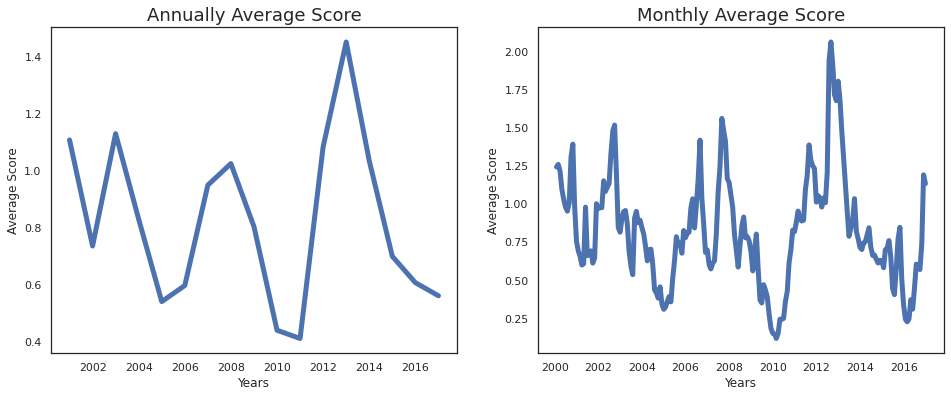

In [18]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
train_dataY = train_data.resample("Y").mean()
plt.plot(train_dataY.score, linewidth=5)
plt.title('Annually Average Score', size=TITLE_SIZE)
plt.xlabel('Years', size=XLABEL_SIZE)
plt.ylabel('Average Score', size=YLABEL_SIZE)

plt.subplot(1, 2, 2)
train_dataM = train_data.resample("M").mean()
plt.plot(train_dataM.score, linewidth=5)
plt.title('Monthly Average Score', size=TITLE_SIZE)
plt.xlabel('Years', size=XLABEL_SIZE)
plt.ylabel('Average Score', size=YLABEL_SIZE)

plt.show()

**Annually Average Score:**
* It seems that there is no monotonic trend, but there are ups and downs.

* At 2011 the average score was 0.4 which is the lowest average score from 2000 to 2016.

* There is a sharp increase from 2011 to 2013 - the highset record was noted in 2013 and is approximately 1.5.

**Monthly Average Score:**
* Every year starts with high average score, than it drops down and at the end it increases up again.

* We can see as well a sharp increase by the years 2011-2013. 






#####4.4.2. Resampling the Data by weeks



*   We will work with data resampled by weeks.



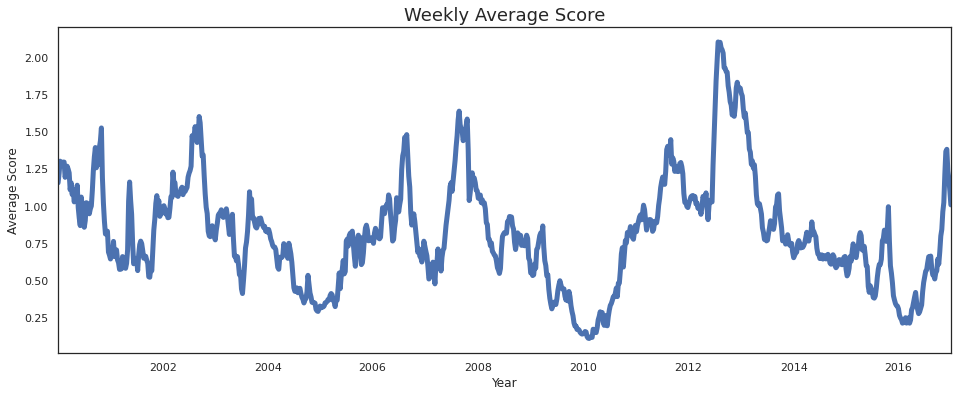

In [19]:
dfw = train_data.resample("W").mean()
dfw.score.plot(figsize=(16,6), linewidth=5)
plt.xlabel('Year', fontsize=XLABEL_SIZE)
plt.ylabel('Average Score', fontsize=YLABEL_SIZE)
plt.title('Weekly Average Score', fontsize=TITLE_SIZE)
plt.show()

#####4.4.3. Plot the Rolling Average by Quarters

*   *window size=12 - the average score by Quarters.*


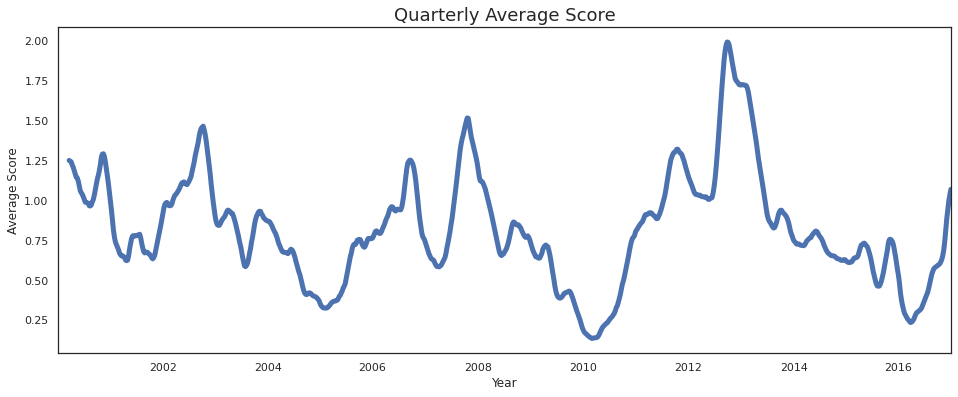

In [20]:
dfw.score.rolling(12).mean().plot(figsize=(16,6), linewidth=5)
plt.xlabel('Year', fontsize=XLABEL_SIZE)
plt.ylabel('Average Score', fontsize=YLABEL_SIZE)
plt.title('Quarterly Average Score', fontsize=TITLE_SIZE)
plt.show()

Both graphs, from part **4.4.2** and **4.4.3** helps us understand about Seasonality and Trends in our data:

*   **Seasonality:**
    *  Every year starts with low average score, then the average rises and eventually it decreases again.
    *   It makes sense that in summer the drought score is higher than in winter.
    * to conclude: our data has seasonality.

*   **Trends:**
    * There are years with high drought score, but also years with very low score.
    * We can see intermittent ups and downs over the years 2000-2016.
    * to conclude: our data has Trends.




#####4.4.4 Autocorrelation



*   To understand better if our data is stationary, let's take a look at the ACF graph: 



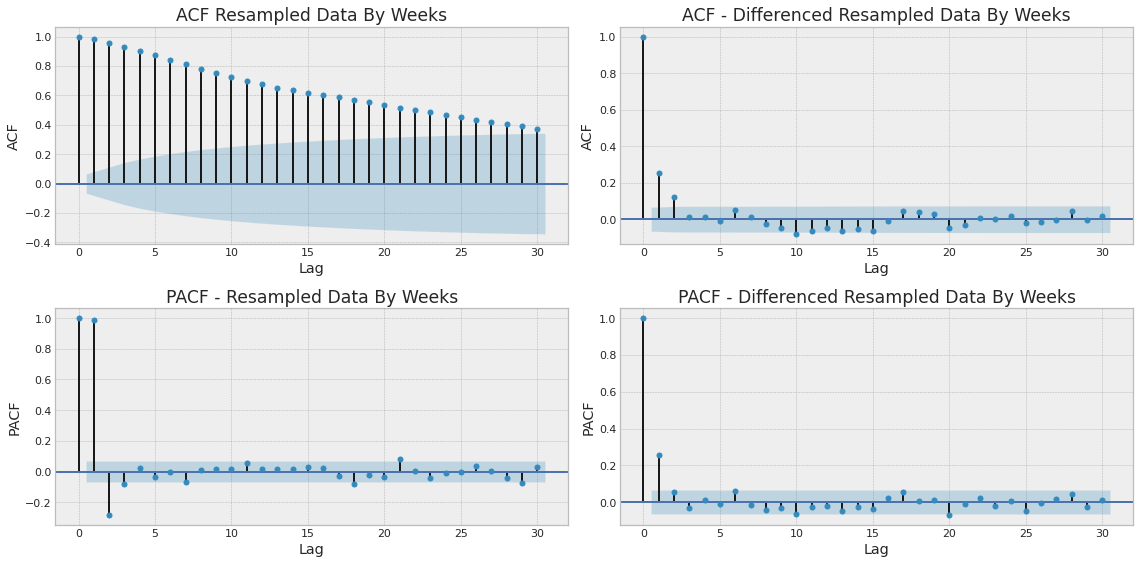

In [21]:
def tsplot(y, lags=None, figsize=(16, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):  
        fig = plt.figure(constrained_layout=True, figsize=figsize)
        spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
        acf_ax = fig.add_subplot(spec2[0, 0], xlabel='Lag', ylabel='ACF')
        dacf_ax = fig.add_subplot(spec2[0, 1], xlabel='Lag', ylabel='ACF')
        pacf_ax = fig.add_subplot(spec2[1, 0], xlabel='Lag', ylabel='PACF')
        dpacf_ax = fig.add_subplot(spec2[1, 1], xlabel='Lag', ylabel='PACF')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, title='ACF Resampled Data By Weeks')
        smt.graphics.plot_acf(y.diff().dropna(), lags=lags, ax=dacf_ax, title='ACF - Differenced Resampled Data By Weeks')
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, title='PACF - Resampled Data By Weeks')
        smt.graphics.plot_pacf(y.diff().dropna(), lags=lags, ax=dpacf_ax, title='PACF - Differenced Resampled Data By Weeks')
        plt.tight_layout()
        
tsplot(dfw.score, lags=30)

* The ACF (top left graph) declines slowly toward zero, hence the data is **non-stationary**. Another cause is that the mean and variance are inconstant, as seen on 4.4.3.

* Adding a 1st order difference to our data (top right graph) shows that the ACF drops to zero relatively quickly. That means the data is **stationary** after 1st order of difference, so we don't need a 2nd order difference.

* Below you can see the graph of the 1st order difference.

* We also created PACF graphs that will help us in the next Part - Arima model.

* The number of Lags we chose is 30 based on the formula: $10 × \log_{10}(length)$ for a time series data as recommended in the article https://methods.sagepub.com/base/download/DatasetStudentGuide/time-series-acf-pacf-in-us-feedgrains-1876-2015.





#####4.4.5. First Order Difference 

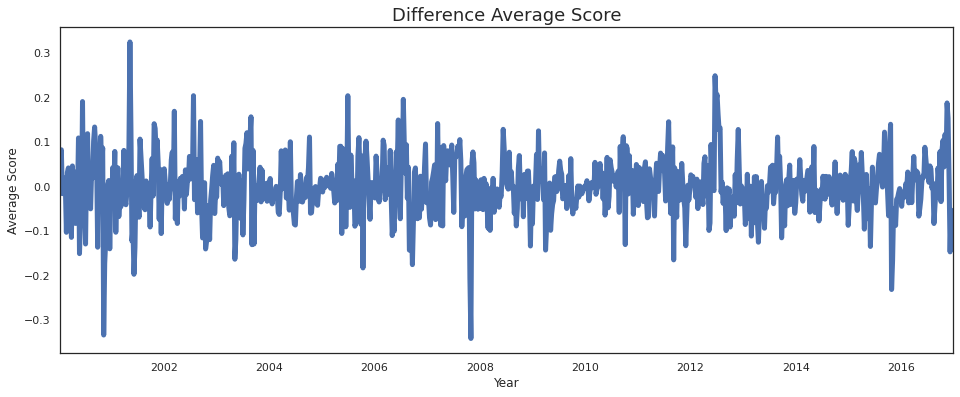

In [22]:
dfw_diff = dfw.diff().dropna()
dfw_diff.score.plot(figsize=(16,6), linewidth=5)
plt.xlabel('Year', fontsize=XLABEL_SIZE)
plt.ylabel('Average Score', fontsize=YLABEL_SIZE)
plt.title('Difference Average Score', fontsize=TITLE_SIZE)
plt.show()

 

*   From the graph we can see unusual peaks around the year: 2001, 2002, 2008, 2012 and 2016.
*   Here are some explanations for these peaks: (Taken From Wikipedia) 

  * *Note:* **What happened in 2002?** 
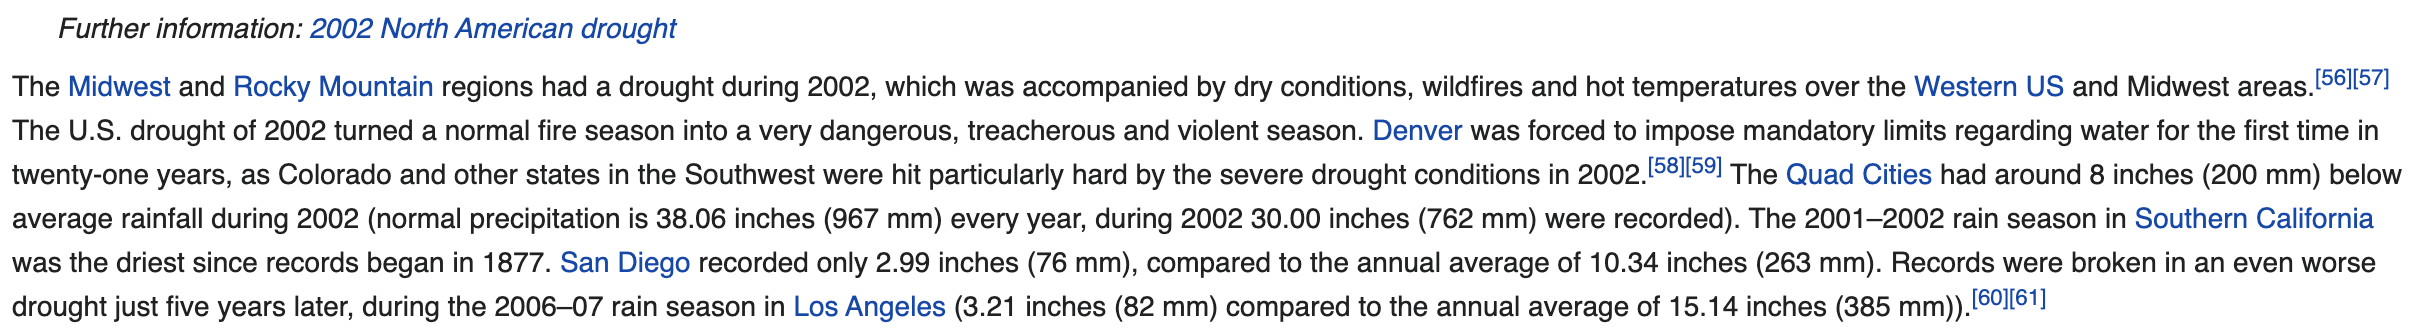

  * *Note:* **What happened in 2012**?
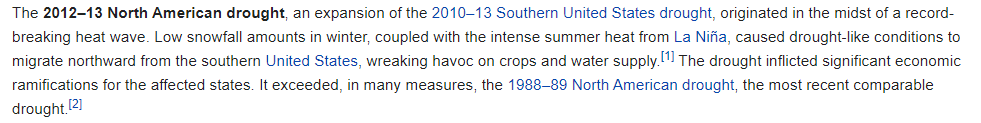

## Part 5 - Base Model



*   We chose a linear regression model named **Lasso**.
*   Lasso is a popular regularization L1 model. It adds to the loss function absolute values of the coefficients. During the optimization process coefficients of unimportant features may become zeroes, so Lasso regression allows for automated feature selection.
*   The code is taken from https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3



####5.1. Lasso Regressor

In [34]:
def lasso_regressor(x_train, y_train):
  lasso = LassoCV(max_iter=100000, tol=0.01, normalize=True)
  lasso.fit(x_train, y_train)
  return lasso

####5.2. Run and plot the results

In [35]:
# Create Training (2000-2014) and Test(2014-2016).
train = dfw[:731]
test = dfw[731:]

# Split the dataset to data without labels and labels only.
x_train, y_train = split_dataset_to_data_and_labels(train)
x_test, y_test = split_dataset_to_data_and_labels(test)

# Fit the Lasso regressor and predict the test set.
lasso = lasso_regressor(x_train, y_train)
prediction = lasso.predict(x_test)

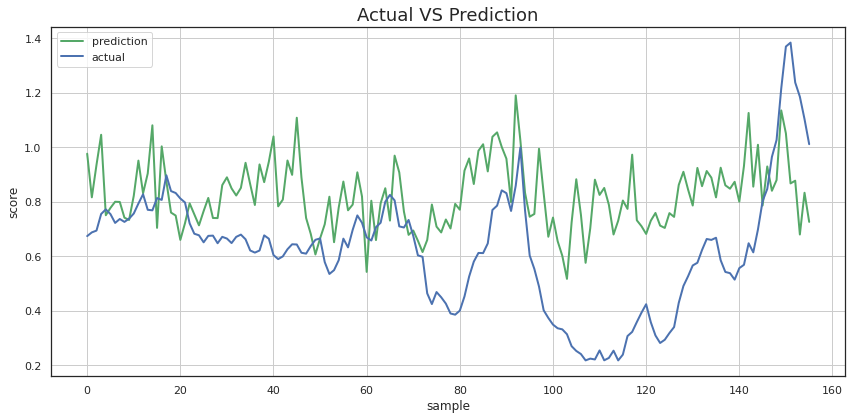

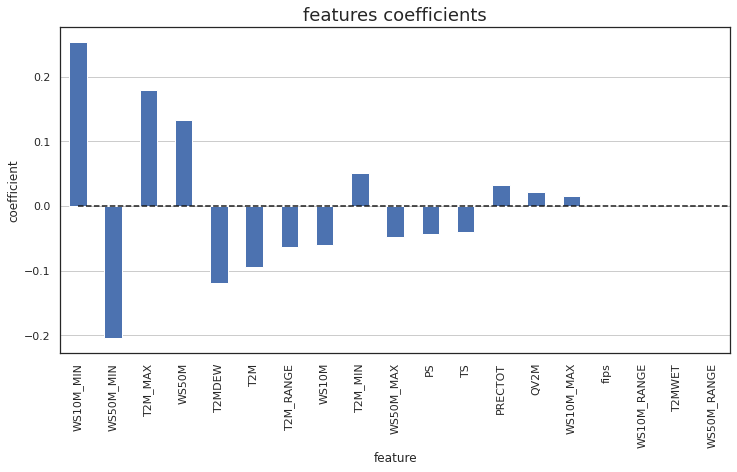

In [36]:
# Plot the running results.
plotModelResults(lasso, X_train=x_train, y_train=y_train, X_test=x_test, y_test=y_test)
plotCoefficients(lasso, x_train)

*   In the upper graph we see the comparation between the actual values (blue line) and the predicted values (green line).
*   In the lower graph we see the features coefficients that can teach us about the important features. Lasso dropped 4 features - fips, WS10M_RANGE, T2MWET, WS50M_RANGE.

####5.3. Choosing the Error Function



*   Comparation between 3 loss functions: 
    *   MAE - Mean Absolute Error (L1 Loss)
    *   MSE - Mean Squared Error (L2 loss)
    *   MAPE -  Mean Absolute Percentage Error




In [37]:
def compare_errors(y_true, y_pred):
  print("True | Pred | MAE  | MSE  | MAPE")
  for true, pred in zip(y_true, y_pred):
    mae = np.sum(np.abs(true - pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    mse = np.sum((true - pred)**2)
    print("{0:.2f} |".format(true), "{0:.2f} |".format(pred), "{0:.2f} |".format(mae), "{0:.2f} |".format(mse), "{0:.2f}%".format(mape))
compare_errors(y_test, prediction)

True | Pred | MAE  | MSE  | MAPE
0.67 | 0.98 | 0.30 | 0.09 | 44.88%
0.69 | 0.82 | 0.13 | 0.02 | 18.73%
0.69 | 0.94 | 0.24 | 0.06 | 34.75%
0.76 | 1.05 | 0.29 | 0.08 | 38.52%
0.77 | 0.75 | 0.02 | 0.00 | 2.78%
0.75 | 0.78 | 0.02 | 0.00 | 3.02%
0.72 | 0.80 | 0.08 | 0.01 | 10.77%
0.74 | 0.80 | 0.06 | 0.00 | 8.49%
0.73 | 0.74 | 0.02 | 0.00 | 2.13%
0.74 | 0.73 | 0.00 | 0.00 | 0.64%
0.76 | 0.82 | 0.06 | 0.00 | 8.58%
0.79 | 0.95 | 0.16 | 0.02 | 19.86%
0.83 | 0.83 | 0.00 | 0.00 | 0.42%
0.77 | 0.90 | 0.13 | 0.02 | 17.29%
0.77 | 1.08 | 0.31 | 0.10 | 40.61%
0.81 | 0.70 | 0.11 | 0.01 | 13.46%
0.81 | 1.00 | 0.20 | 0.04 | 24.37%
0.90 | 0.87 | 0.02 | 0.00 | 2.50%
0.84 | 0.76 | 0.08 | 0.01 | 9.41%
0.83 | 0.75 | 0.08 | 0.01 | 9.95%
0.81 | 0.66 | 0.15 | 0.02 | 18.72%
0.80 | 0.72 | 0.08 | 0.01 | 9.54%
0.72 | 0.79 | 0.07 | 0.01 | 10.20%
0.68 | 0.75 | 0.07 | 0.01 | 10.46%
0.68 | 0.71 | 0.04 | 0.00 | 5.39%
0.65 | 0.77 | 0.11 | 0.01 | 17.61%
0.67 | 0.81 | 0.14 | 0.02 | 20.63%
0.68 | 0.74 | 0.06 | 0.00 | 9.57%


In [38]:
error = mean_absolute_percentage_error(y_test, prediction)
print("Mean Absolute Percentage Error: {0:.2f}%".format(error))
print("Mean Absolute Error: {0:.2f}".format(mean_absolute_error(y_test, prediction)))
print("Mean Squared Error: {0:.2f}".format(mean_squared_error(y_test, prediction)))

Mean Absolute Percentage Error: 56.06%
Mean Absolute Error: 0.25
Mean Squared Error: 0.09



Based on the comparation above:
*   The Mean Absolute Error is better than the Mean Squared Error because it is more precise. In our case, the residuals (errors) are so close to zero, so the MSE is also very close to zero or zero.
*   We chose to use the Mean Absolute Percentage Error because the percentage is equivalent to MAE, but it is easier to conceptualize the error.

*   So, from now on we will use the MAPE to calculate the error. 



####5.4. Cross Validation



*   After choosing the error function, we will it in the cross validation process to minimise the error.



In [39]:
X, y = split_dataset_to_data_and_labels(dfw)
cross_validation_lasso(X, y)

Train size: 86, Test size: 79, Mean Absolute Percentage Error: 18.99397015164237%
Train size: 166, Test size: 79, Mean Absolute Percentage Error: 50.462836772688945%
Train size: 246, Test size: 79, Mean Absolute Percentage Error: 67.69618532020719%
Train size: 326, Test size: 79, Mean Absolute Percentage Error: 26.129572033067213%
Train size: 406, Test size: 79, Mean Absolute Percentage Error: 21.381060931279563%
Train size: 486, Test size: 79, Mean Absolute Percentage Error: 207.05494676461745%
Train size: 566, Test size: 79, Mean Absolute Percentage Error: 25.51415824166367%
Train size: 646, Test size: 79, Mean Absolute Percentage Error: 31.915583766639095%
Train size: 726, Test size: 79, Mean Absolute Percentage Error: 22.356276447471387%
Train size: 806, Test size: 79, Mean Absolute Percentage Error: 86.69256407961625%




*   Above you can see the results of the cross validation.
*   the split we chose is: 
    * train size:  (726, 19)
    * test size:  (79, 19)
    * Mean Absolute Percentage Error: 22.36%
*   We chosed that because the training set and the test set size together are almost in the size of the original set.
*   Now, Let's run the Lasso model with training set on size (726, 19) and test set on size (79, 19):



In [41]:
X_train, X_test = X.iloc[:726], X.iloc[726:805]
y_train, y_test = y.iloc[:726], y.iloc[726:805]
prediction = lasso_regressor(X_train, y_train).predict(X_test)
error = mean_absolute_percentage_error(y_test, prediction)
print("Train size: {}, Test size: {}, Mean Absolute Percentage Error: {}%".format(X_train.shape[0], X_test.shape[0],error))

Train size: 726, Test size: 79, Mean Absolute Percentage Error: 21.393646603680608%


## Part 6 - Basic Model Explainability



*   In this part we will explain the results of the Basic Model, identify it's error and will try to understand why those errors happened.


#####6.1. Residuals - Calculate the Maximum Error on the test set.

In [103]:
residuals = y_test - prediction
max_error = max(prediction) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], prediction[max_idx]
print("Max Error:", "{:.2f}".format(max_error))
print("Max True: {:.2f}, Max Prediction: {:.2f}".format(max_true, max_pred))

Max Error: -0.47
Max True: 0.64, Max Prediction: 1.11


#####6.2. Residuals Histogram

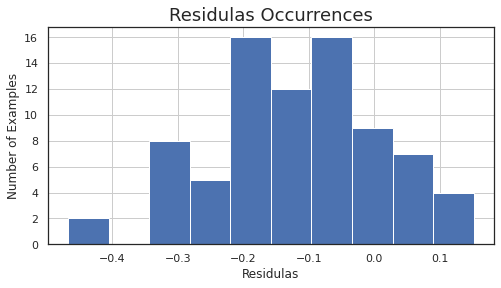

In [104]:
residuals.hist(figsize=FIG_SIZE)
plt.xlabel('Residulas', fontsize=XLABEL_SIZE)
plt.ylabel('Number of Examples', fontsize=YLABEL_SIZE)
plt.title('Residulas Occurrences', fontsize=TITLE_SIZE)
plt.show()

*   Negative residuals => y_true < y_prediction => over estimates
*   The miskates range is wide scale from -0.47 to 0.2.
*   We can see a tendency to predict the score higher than it should be.
*   Also, there is a significant peaks in -0.2 and 0.0.



#####6.3. Plot the True Values Against the Predicted Values in absolute value and percentage

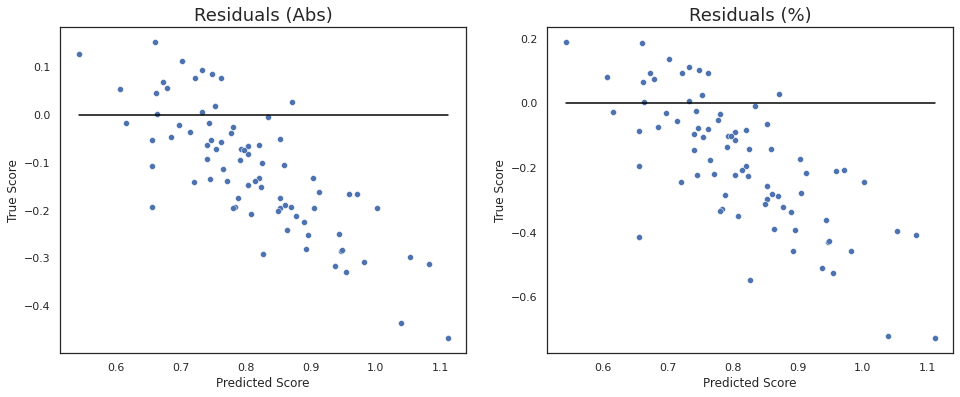

In [105]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
sns.scatterplot(x=prediction,y=residuals,ax=ax[0])
sns.lineplot(x=prediction,y=0,ax=ax[0],color='black')
ax[0].set_title("Residuals (Abs)", fontsize=TITLE_SIZE)
ax[0].set_xlabel('Predicted Score', fontsize=XLABEL_SIZE);
ax[0].set_ylabel('True Score', fontsize=YLABEL_SIZE);

# The error percentage out of the scores value
sns.scatterplot(x=prediction,y=residuals/y_test,ax=ax[1])
sns.lineplot(x=prediction,y=0,ax=ax[1],color='black')
ax[1].set_title('Residuals (%)', fontsize=TITLE_SIZE)
ax[1].set_xlabel('Predicted Score', fontsize=XLABEL_SIZE);
ax[1].set_ylabel('True Score', fontsize=YLABEL_SIZE);
plt.show()

*   Clearly the Lasso's predictions are higher than they should be.
*   In most cases the model over estimates the score.

#####6.4. Explore and understand on which examples we predicted best (and worst...)

In [106]:
rel_res=residuals/y_test
rel_res=rel_res.abs()

*   Our model works best (error less than 5%) for 11% of the test data

In [107]:
len(rel_res[rel_res<0.05])/len(rel_res)

0.11392405063291139

*   Our model had bigger mistakes (more than 20%) on 47% of the test data

In [108]:
len(rel_res[rel_res>0.2])/len(rel_res)

0.46835443037974683

#####6.5. Model explainability using **SHAP**

In [109]:
shap_sample = X_train.sample(500)

In [110]:
explainer = shap.Explainer(lasso.predict, shap_sample)
shap_values = explainer(shap_sample)

Permutation explainer: 501it [00:15, 10.97it/s]                         


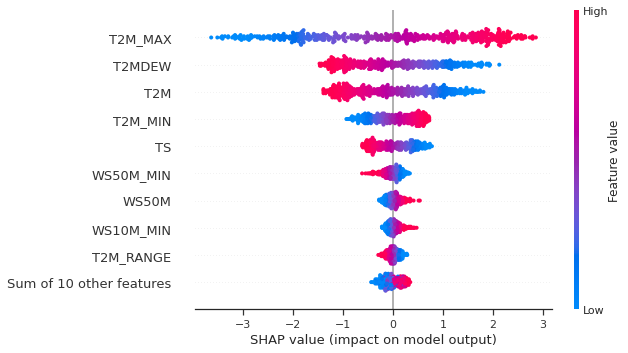

In [111]:
shap.plots.beeswarm(shap_values)


*   Overall, the features impact the same way on the score. In all cases we can see symmetrical results with high values and low.
*   for example, in T2M_MAX when the value is low, the impact is negative and when the value is high the impact is high. 




In [112]:
test_shap_values = explainer(X_test)



*   Let's explore the sample that got the highset residual.


In [113]:
rel_res[rel_res==rel_res.max()]

date
2014-11-23    0.726885
Freq: W-SUN, Name: score, dtype: float64

In [114]:
X_test.index.get_loc('2014-11-23')

50

In [115]:
X_test[rel_res==rel_res.max()]

fips   PRECTOT         PS  ...  WS50M_MAX  WS50M_MIN  WS50M_RANGE
date                                          ...                                   
2014-11-23  30670.37677  0.192648  97.036721  ...   9.025586   4.610901     4.414585

[1 rows x 19 columns]

In [116]:
y_test.loc['2014-11-23'],prediction[50]

(0.6432366151866156, 1.1107954217492813)

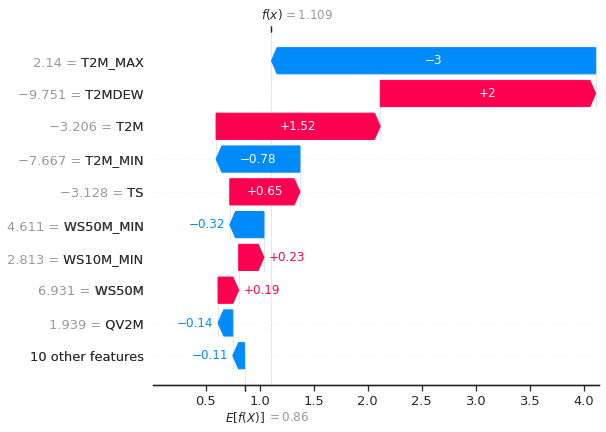

In [117]:
shap.plots.waterfall(test_shap_values[50])



*   We can see that T2M_MAX has high impact on the score in the negative way. But, the T2MDEW and T2M cancel that impact with high positive values. 
*   Below we can see boxplots for the three most influence features.



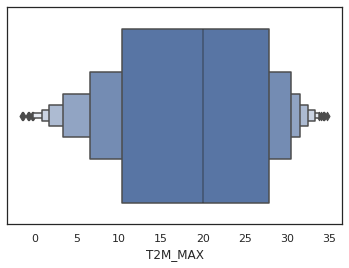

In [118]:
sns.boxenplot(x=X_train.T2M_MAX)

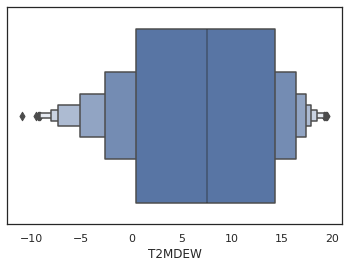

In [119]:
sns.boxenplot(x=X_train.T2MDEW)

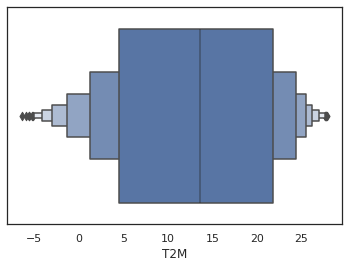

In [120]:
sns.boxenplot(x=X_train.T2M)



*   Overall, there aren't significant outliers. Therefore, no action required to improve the data.


In [121]:
len(residuals[residuals<-0.1])

43



*   Now, let's focus on the samples with the highest residuals.


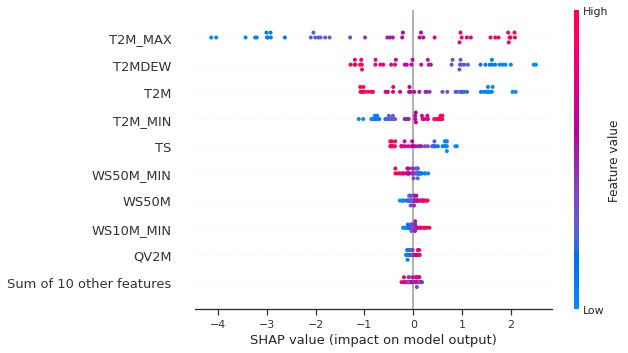

In [122]:
bad_examples = X_test.loc[residuals[residuals<-0.1].index]
bad_examples_shap_values = explainer(bad_examples)
shap.plots.beeswarm(bad_examples_shap_values)



*   We can see that there is an low impact on low values for the T2M_MAX.
*   But, there is also high impact on low values as well for the T2MDEW and T2M.



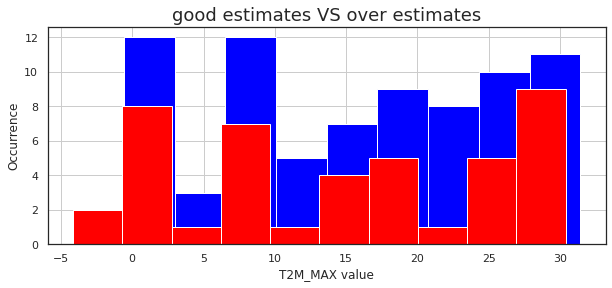

In [123]:
over_estimates = X_test.loc[residuals[residuals<-0.1].index]
good_estimates = X_test.loc[rel_res[rel_res>-0.1].index]
fig, ax = plt.subplots(figsize=(10,4))
good_estimates.T2M_MAX.hist(ax=ax,color='blue')
over_estimates.T2M_MAX.hist(ax=ax,color='red')
plt.xlabel("T2M_MAX value", size=XLABEL_SIZE)
plt.ylabel("Occurrence", size=YLABEL_SIZE)
plt.title("good estimates VS over estimates", size=TITLE_SIZE)
plt.show()



*   Based on those visualizations, we can't conclude any ways to improve the base model (the errors are not related to one specific issue). Therefore, we will train a TimeSeries related model - ARIMA model.


## Part 7 - ARIMA MODEL

####7.1.Choosing the differencing order

Based on the analysis in part 4, the data needs only one order of difference. So, let’s check our results by comparing ARIMA(0, 0, 0) and ARIMA(0, 1, 0) while d = 1 = 1nd order difference.

                              ARMA Model Results                              
Dep. Variable:                  score   No. Observations:                  887
Model:                     ARMA(0, 0)   Log Likelihood                -662.726
Method:                           css   S.D. of innovations              0.511
Date:                Tue, 24 Aug 2021   AIC                           1329.451
Time:                        07:22:50   BIC                           1339.027
Sample:                    01-09-2000   HQIC                          1333.112
                         - 01-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3060      0.017    -17.840      0.000      -0.340      -0.272
                             ARIMA Model Results                              
Dep. Variable:                D.score   No. Observat

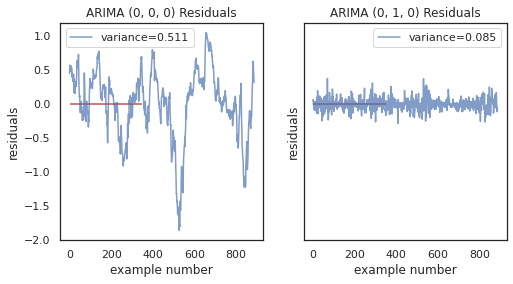

In [43]:
fit_ARIMA(0,0,0,0,1,0)

* The Akaike Information Criterion (AIC) is lower with the ARIMA(0,1,0), meaning 
this model performs better than the ARIMA(0,0,0).

* Also, the variances of the residuals graphs - the ARIMA(0,1,0) variance is lower (0.085) than ARIMA(0,0,0).

* To conclude: d = 1.

####7.2.Choosing the MA order

* Rule: “ If the lag-1 autocorrelation of the differenced series ACF is negative, and/or there is a sharp cutoff, then choose a MA order of 1”.
* Based on that rule we will try to run the model with (1,1,0) and compare it to (0,1,0). results:

                             ARIMA Model Results                              
Dep. Variable:                D.score   No. Observations:                  886
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 950.199
Method:                       css-mle   S.D. of innovations              0.083
Date:                Tue, 24 Aug 2021   AIC                          -1894.399
Time:                        07:22:52   BIC                          -1880.039
Sample:                    01-16-2000   HQIC                         -1888.909
                         - 01-01-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.004     -0.047      0.963      -0.007       0.007
ar.L1.D.score     0.2151      0.033      6.554      0.000       0.151       0.279
                                    Root

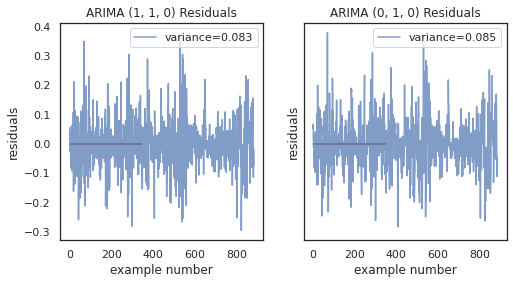

In [44]:
fit_ARIMA(1,1,0,0,1,0)

* The AIC has dropped again and the residuals variance decreased also. That’s a sign our ARIMA(1,1,0) performs better than the ARIMA(0,1,0) !

* To conclude: p = 1

####7.3.Choosing the AR order



*   Rule: “If the lag-1 autocorrelation of the differenced series PACF is negative, and/or there is a sharp cutoff, then choose a AR order of 1.”
*   By this rule and looking at our PACF difference graph we will try to run the model with (1,1,1) and compare it to (1,1,0). 



                             ARIMA Model Results                              
Dep. Variable:                D.score   No. Observations:                  886
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 951.011
Method:                       css-mle   S.D. of innovations              0.083
Date:                Tue, 24 Aug 2021   AIC                          -1894.022
Time:                        07:22:53   BIC                          -1874.875
Sample:                    01-16-2000   HQIC                         -1886.702
                         - 01-01-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.004     -0.045      0.964      -0.007       0.007
ar.L1.D.score     0.4067      0.138      2.946      0.003       0.136       0.677
ma.L1.D.score    -0.2016      0.148     

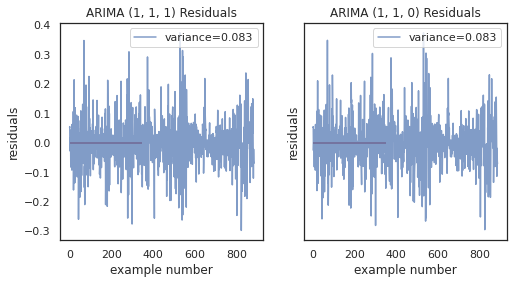

In [45]:
fit_ARIMA(1,1,1,1,1,0)



*   The residuals variances are the same in both cases, but the AIC of ARIMA(1,1,0) is lower than ARIMA(1,1,1).

*   To conclude, the best parameters are (1,1,0).



####7.4.Prediction

*   Now, we will split the dataset using cross validation, then fit the ARIMA model with parameters (1,1,0) and predict on the test set.


In [47]:
X, y = split_dataset_to_data_and_labels(dfw)
cross_validation_arima(X,y)

Train size: 86, Test size: 79, Mean Absolute Percentage Error: 58.095064491202685%
Train size: 166, Test size: 79, Mean Absolute Percentage Error: 39.20617086591445%
Train size: 246, Test size: 79, Mean Absolute Percentage Error: 48.15529518161249%
Train size: 326, Test size: 79, Mean Absolute Percentage Error: 31.829734131383074%
Train size: 406, Test size: 79, Mean Absolute Percentage Error: 103.96324846312139%
Train size: 486, Test size: 79, Mean Absolute Percentage Error: 90.7932926606278%
Train size: 566, Test size: 79, Mean Absolute Percentage Error: 19.888817033784687%
Train size: 646, Test size: 79, Mean Absolute Percentage Error: 29.968183664638314%
Train size: 726, Test size: 79, Mean Absolute Percentage Error: 11.963391485588426%
Train size: 806, Test size: 79, Mean Absolute Percentage Error: 38.33604639565909%


*   The split with the lowest error is: 
    * train size:  (726, 19)
    * test size:  (79, 19)
    * Mean Absolute Percentage Error: 11.96%
*   That the same split we chose before in the CV of Lasso model.
*   Now, Let's run the ARIMA model with training set on size (726, 19) and test set on size (79, 19):

Train size: 726, Test size: 79, Mean Absolute Percentage Error: 11.078118131912824%


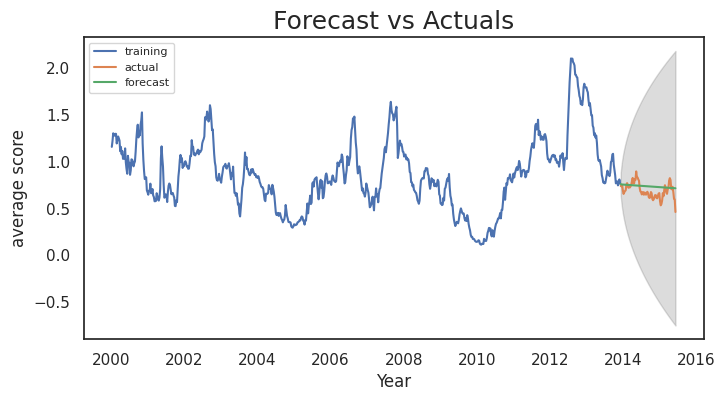

In [49]:
run_arima_and_plot_results(X, y);



*   The model learned the examples of 2000-2014 and predicted the score on 2014-2016.
*   As we can see the forcast (green line) is relatively close to the actual (orange line).



## Part 8 - Conclusions



*   As we saw on part 4, the data has **Seasonality**, **Trends** characterized with ups and downs, and **is not Stationarity**.
*   Our **base model** is **Lasso regressor** that got 23% error.
*   From the basic model explainability, we recognised that the model tends to over estimate the score and the precentage of big mistakes out of all errors is 47%. 
*   From the SHAP explainability we saw that the most considered features are temperature related: T2M_MAX, T2MDEW, T2M and T2M_MIN. 
*   There are also some wind related features that affect the prediction: WS50M_MIN, WS50M and WS10M_MIN. 
*   After performing **first order differencing**, the data became **Stationarity**, so we used the ARIMA model with a difference level of 1 and used cross validation. The amazing result was that we got 11% error.
*   The error we used is Mean Absolute Percentage Error as we explained in part 5.3.
*   At first we tried to refer the problem as a **classification** one. However, we understood that the classification model **Logistic Regression** didn't succeed to learn the data characteristics. Therefore, we decided to focus on the problem as a regression one. 
*   We learned that the time element is important in order to predict reliable results (the **RandomForestRegressor** had an error rate of 60%! - see attachments).
*   We understood the importance of differencing, and in particular first and second levels of differencing. On this case, we didn't need a second order differncing because after the first one the data received was Stationary.



*   The dataset that we chose was a challenge, however we made the most of it while we developed and matured as data scientists. 
*   Thank you for your time !





## Part 9 - Attachments

####1. Features correlation with first order differences on the data

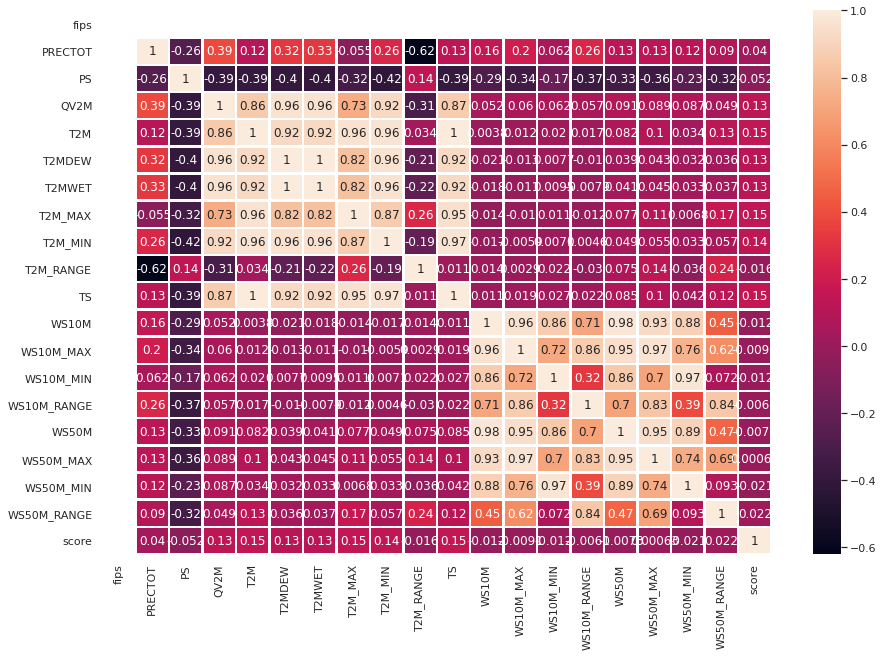

In [135]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(dfw.diff().corr(method='spearman'),annot=True,linewidths=1.5, ax=ax)
plt.show()

*   As we can see, the features with the highest correlations with the Score are:
    * T2M, T2M_MAX, TS - 0.15
    * T2M_MIN - 0.14
    * QV2M, T2NDEW, T2MWET - 0.13


####2. Logistic Regression Model 


*   First, we designed our question as Classification one - "What will be the drought level next week?" (levels: no drought, D0, D1, D2, D3, D4).
*   Here there is a try to run Logistic Regression Model for Classification question. 



#####2.1. Preprocessing

In [150]:
logreg = linear_model.LogisticRegression(max_iter = 10000)

#Seperate the score label from train_data
train = train_data.copy()
score_labels = train.score
train_data_no_score = train.drop('score',axis=1)
categorical_scores = convert_reg_score_to_categories(score_labels)

train_data_no_score = train_data_no_score[:100000]
categorical_scores = categorical_scores[:100000]

#####2.2. Fitting the Logistic Regression Model



*   Fitting the model may take a while (5-6 minutes).
*   Unfortunately, we can't skip this because we run to this error when we tried to predict: 'This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.'



In [155]:
logreg.fit(train_data_no_score, categorical_scores)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#####2.3. Evaluate Results on the Validation Set

In [156]:
validation = validation_data.copy()
validation_score_labels = validation.score
validation_no_score = validation.drop('score',axis=1)
categorical_scores_validation = convert_reg_score_to_categories(validation_score_labels)

In [157]:
predicted = logreg.predict(validation_no_score)
predicted_probs = logreg.predict_proba(validation_no_score)

print(metrics.classification_report(categorical_scores_validation[:100000], predicted[:100000]))

              precision    recall  f1-score   support

           0       0.72      0.97      0.83     70942
           1       0.27      0.03      0.05     16819
           2       0.13      0.05      0.07      7491
           3       0.16      0.00      0.00      3401
           4       0.00      0.00      0.00      1171
           5       0.00      0.00      0.00       176

    accuracy                           0.70    100000
   macro avg       0.21      0.17      0.16    100000
weighted avg       0.57      0.70      0.60    100000





*   We evaluate the model on 100,000 samples only, otherwise the session is crashing.
*   From the report we can see that the accuracy is 0.7.
*   The precisions and recalls are high for the samples with 0 (no drought), but very low in other levels of drought.
*   Most of the samples are with no drought. 



#####2.4. Evaluate Results on the Test Set 

In [158]:
test = test_data.copy()
test_score_labels = test.score
test_no_score = test.drop('score',axis=1)
categorical_scores_test = convert_reg_score_to_categories(test_score_labels)

In [159]:
predicted = logreg.predict(test_no_score)
predicted_probs = logreg.predict_proba(test_no_score)

print(metrics.classification_report(categorical_scores_validation[:100000], predicted[:100000]))

              precision    recall  f1-score   support

           0       0.72      0.96      0.82     70942
           1       0.22      0.03      0.05     16819
           2       0.19      0.07      0.11      7491
           3       0.00      0.00      0.00      3401
           4       0.00      0.00      0.00      1171
           5       0.00      0.00      0.00       176

    accuracy                           0.69    100000
   macro avg       0.19      0.18      0.16    100000
weighted avg       0.56      0.69      0.60    100000





*   The results of the test set are approximately the same as on the validation set.
*   List item



In [160]:
y_true = categorical_scores_test
y_score = predicted_probs

n_classes = 6
y = label_binarize(y_true, classes=np.arange(n_classes))

#####2.5. Precision-Recall Curve

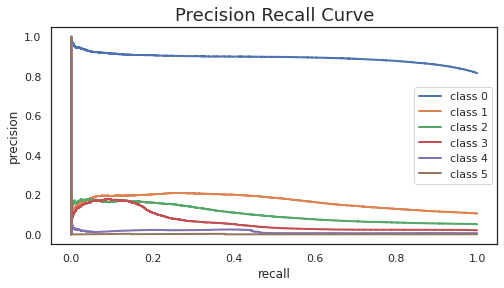

In [161]:
precision = dict()
recall = dict()

plt.figure(figsize=FIG_SIZE)
for i in range(n_classes):
    precision[i], recall[i], _ = sklearn.metrics.precision_recall_curve(y[:, i], y_score[:, i], pos_label=1)
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall", fontsize=XLABEL_SIZE)
plt.ylabel("precision", fontsize=YLABEL_SIZE)
plt.legend(loc="best")
plt.title("Precision Recall Curve", fontsize=TITLE_SIZE)
plt.show()



*   The precision Recall Curve shows the tradeoff between precision and recall for different threshold.
*   The area under the curve in **class 0** is high, so the recall and precision are both high as we saw before in the report.
*   The other classes have low area under the curve which represents both low recall and precision.
*   High precision relates to a low false positive rate, and high recall relates to a low false. That's true for class 0. For the other classes we’re gonna need to make some improvements. 



#####2.6. ROC Curve

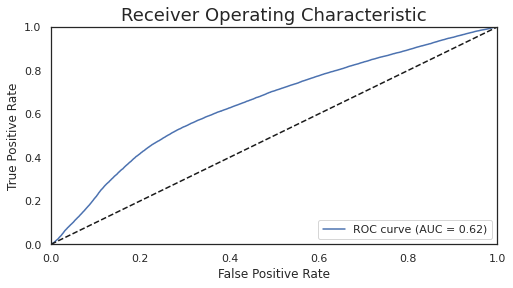

In [163]:
auc = sklearn.metrics.roc_auc_score(y_true, y_score, multi_class='ovr')
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score[:, 1], pos_label=1)
plotRoc(fpr, tpr, auc)



*   The AUC is 0.62 which is quite good for the Basic Model, but we’re gonna need to make some improvements so the true positive rate will be close to 1 and thhe false positive rate will be close to 0.
*   Our goal is to close the curve to 1.0 in the true positive rate.



#####2.7. Conclusions


*   Given another thought about this model, we decided to rephrase our question and to solve a Regression problem: 

  *   "What will be the score next week?" (a number between 0-5)
*   We decided that because we understood that the model looses important information while designing as Classification problem. 

*   In the next step, we spent more time to explore the Seasonality, Trends and Stationary of the data. than, we tried models that desighed specifically for time series data that solves a Regression problem, but also models for stationary data.





####3. Checking the best parameters for SARIMA Model



*   Let's check the best parameters for SARIMA Model
*   This can take some time (25 minutes).
*   If you wish to run this code please change SKIP = False


In [54]:
SKIP = True
if SKIP:
  f = open('sarima_best_params.txt', 'r')
  file_contents = f.read()
  print (file_contents)
  f.close()
else:
  train_st = dfw.score[:731]
  test_st = dfw.score[731:]
  p = range(0, 3)
  d = range(0,2)
  q = range(0, 3)
  pdq = list(itertools.product(p, d, q))
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
  print('Examples of parameter combinations for Seasonal ARIMA...')
  print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
  print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
  print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
  print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
  aic = []
  params = []
  params_seasonal = []
  for param in pdq:
      for param_seasonal in seasonal_pdq:
          try:
              mod = SARIMAX(train_st, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
              results = mod.fit()
              aic.append(results.aic)
              params.append(param)
              params_seasonal.append(param_seasonal)
              print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
          except:
              continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1990.8018345106975
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1280.7372631135217
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:863.4445500191855
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:294.8463218445687
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:280.5029751761383
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:277.6429853884143
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:270.9112064348911
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:263.09013775260917
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:264.48442632015735
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:282.5812826586785
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:228.70888503070626
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:226.4863728516819
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:266.63827805173594
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:228.99611087435758
ARIMA(0, 0, 0)x(2, 0, 2, 1


*   Given a collection of parameters for the data, the AIC estimates the quality of each parameters on the model. The parameters (1,1,0) from ARIMA and the the seasonal parameters (0,0,0,12) got one of the lowest AIC. 
*   Because of the seasonal parameters are zero, we should not try the SARIMA Model.




####4. Random Forest Regresssor

#####4.1. Methods

In [141]:
def tune(dataset_without_labels, lables):
  model = RandomForestRegressor()
  gcv = GridSearchCV(model, {"max_features": [2, 4, 6, 8, 10, 12], "n_estimators": [100, 200, 500, 1000], "max_depth": [3, 4, 5]}, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
  gcv.fit(dataset_without_labels, lables)
  return gcv.best_params_

In [142]:
def fit(best_params, dataset_without_labels, lables):
  model = RandomForestRegressor(n_estimators=best_params["n_estimators"],
                                max_depth=best_params["max_depth"],
                                max_features=best_params["max_features"])
  model.fit(dataset_without_labels, lables)
  return model

#####4.2. Splitting to train and test

In [143]:
# Create Training and Test
train = dfw[:731]
test = dfw[731:]

#####4.3. Fitting the model on the train set



*   Finding the best parameters can take a while (5 minutes).
*   You can skip this process, or if you wish to run it please change SKIP = False



In [146]:
SKIP = True
train_data_without_labels, train_labels = split_dataset_to_data_and_labels(train)
if SKIP:
  best_params = {'max_depth': 5, 'max_features': 6, 'n_estimators': 100}
else:
  best_params = tune(train_data_without_labels, train_labels)
model = fit(best_params, train_data_without_labels, train_labels)

#####4.4. Prediction

In [148]:
test_data_without_labels, test_labels = split_dataset_to_data_and_labels(test)
predicted = model.predict(test_data_without_labels)

error = mean_absolute_percentage_error(test_labels, predicted)
print("Mean Absolute Percentage Error: {0:.2f}%".format(error))

Mean Absolute Percentage Error: 60.07%


####5. Ridge Regressor

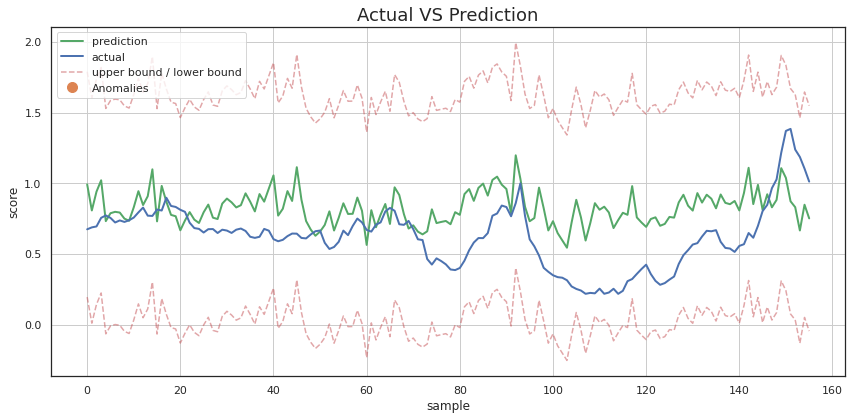

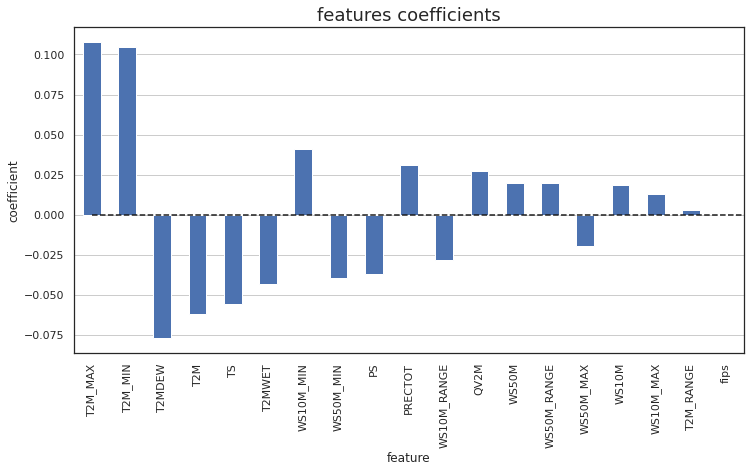

In [138]:
train = dfw[:731]
test = dfw[731:]

x_train, y_train = split_dataset_to_data_and_labels(train)
x_test, y_test = split_dataset_to_data_and_labels(test)

ridge = RidgeCV()
ridge.fit(x_train, y_train)

plotModelResults(ridge,
                 X_train=x_train,
                 y_train=y_train, 
                 X_test=x_test, 
                 y_test=y_test,
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge, x_train)

In [139]:
prediction = ridge.predict(x_test)
error = mean_absolute_percentage_error(y_test, prediction)
print("Mean Absolute Percentage Error: {0:.2f}%".format(error))

Mean Absolute Percentage Error: 56.20%




*   Here the constrains are the sum of squares of coefficients, multiplied by the regularization coefficient.
*   We can clearly see how coefficients are getting closer and closer to zero, as their importance in the model drops



####6. XGBoost

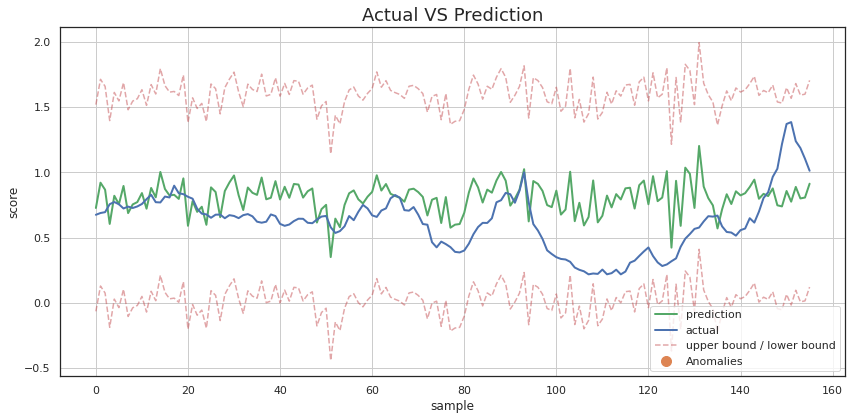

In [137]:
train = dfw[:731]
test = dfw[731:]

x_train, y_train = split_dataset_to_data_and_labels(train)
x_test, y_test = split_dataset_to_data_and_labels(test)

xgb = XGBRegressor(silent=True)
xgb.fit(x_train, y_train)

plotModelResults(xgb, 
                 X_train=x_train,
                 y_train=y_train, 
                 X_test=x_test, 
                 y_test=y_test, 
                 plot_intervals=True, plot_anomalies=True)

In [140]:
prediction = xgb.predict(x_test)
error = mean_absolute_percentage_error(y_test, prediction)
print("Mean Absolute Percentage Error: {0:.2f}%".format(error))

Mean Absolute Percentage Error: 55.83%




*   XGBoost got the smallest error on the test set than the 2 models above.
*   XGBoost also dropped 4 features completely.

